<a href="https://colab.research.google.com/github/thierrypdamiba/examples/blob/master/Qdrant_Zoom_Relari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qdrant <> Relari Webinar Notebook

Welcome to the Qdrant <> Relari Webinar Notebook. We walked through this notebook in a [joint webinar](https://lu.ma/u5sgzulm).

In this notebook we will walk through a simple case study of building RAG systems with Qdrant and optimizing with Relari.

Check out the blog post for more context.


## 0. Getting started

In [ ]:
%%capture
!pip install relari langchain_community  langchain_qdrant qdrant-client[fastembed]
!pip install unstructured rank_bm25
!pip install --upgrade nltk

### Add Relari API key as colab secrets


In [ ]:
from google.colab import userdata
import os

os.environ['RELARI_API_KEY'] = userdata.get('RELARI_API_KEY')
os.environ['QDRANT_API_KEY'] = userdata.get('QDRANT_API_KEY')
os.environ['QDRANT_URL'] = userdata.get('QDRANT_URL')
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')




Now we can instantiate the `RelariClient`.

In [ ]:
from relari import RelariClient
client = RelariClient()

## 1. Create a Project

A project is wehere you organize your datasets, experiments, prompts. Every time you work on a new application or feature you should create a new project.

In [ ]:
proj = client.projects.create(name="Qdrant Zoomer")

for project in client.projects.list():
    print(f"ID:   {project['id']}")
    print(f"Name: {project['name']}\n")

ID:   66db4a67675698f023a7fd5d
Name: Gitlab Employee Assistant

ID:   66e0cd76e7d8dcf496292b2d
Name: Gitlab Employee Assistant

ID:   66e0d21ae7d8dcf496292b2e
Name: Gitlab Employee Assistant

ID:   66e39e4de7d8dcf496292b71
Name: Gitlab Employee Assistant

ID:   66f72b668a49745ec63ccf0e
Name: Qdrant Zoom

ID:   66f780b58a49745ec63ccf24
Name: Qdrant Zoomer

ID:   66f78f178a49745ec63ccf29
Name: Qdrant Zoomer



You can also find previous project by name (warning: names do not need to be unique so it might return a list)

In [ ]:
proj = client.projects.find_one(name="Qdrant Zoomer")
print(proj)

{'id': '66f780b58a49745ec63ccf24', 'name': 'Qdrant Zoomer'}


In [ ]:
dataset_info = client.datasets.find_one(proj["id"], name="Qdrant Zoomers Calls")
dataset = client.datasets.get(dataset_info["id"])
print(len(dataset))
print(dataset.data[0])
print(dataset.fields)

30
{'uid': 'a8cy9ra0', 'metadata': {'tone': 'professional', 'type': 'factual', 'topics': ['Financial Strategy and Budget Planning'], 'difficulty': 'easy'}, 'question': 'What was discussed in the Finance Meeting?', 'context_metadata': {'type': 'multi-context', 'sources': [{'source': '/tmp/relari/p70udh/user_3VLIiHt8SF8hswXNWa4JUD.txt'}, {'source': '/tmp/relari/p70udh/user_3VLIiHt8SF8hswXNWa4JUD.txt'}, {'source': '/tmp/relari/p70udh/user_Z067kxDMhRWI6kIW1tKsr3.txt'}]}}
[DatasetField(name='uid', type=<class 'str'>, description='Uid', is_ground_truth=False), DatasetField(name='metadata', type=<class 'dict'>, description='Question Metadata', is_ground_truth=False), DatasetField(name='question', type=<class 'str'>, description='The question to be answered', is_ground_truth=False), DatasetField(name='context_metadata', type=<class 'dict'>, description='Context Metadata', is_ground_truth=True)]


## 2. Define a Golden Dataset

A dataset is the foundation of data-driven AI development. Dataset should contain all input and expected outputs of your system to be used to measure and improve applications.


![dataset options](https://cdn.prod.website-files.com/669f7329c898141d69e166b3/669fc9ef4152b38ac1739cdd_1*l2NiinjiKitQGEUoH3-1Lg.png)

Datasets are essential in Relari's approach to evaluate and improve LLM applications. The data is used as ground-truth (or in other words as reference) to test an LLM application pipeline. Learn more about our data-driven approach [here](https://docs.relari.ai/getting-started/datasets/intro).

You can think a dataset as an  exam rubric. It would include questions, correct answers, and the correct intermediate steps to get to the answer (for example from which page of the book we can get the answer). We then give the same exam questions to our AI application, and see how well the generated answer matches up the expected answer. Using these questions, we evaluate results to measure the capability of the AI application and find wrong answers / steps to improve upon.

![Synth data](https://cdn.prod.website-files.com/669f7329c898141d69e166b3/669fc9f0e1c64698f4b9a2d5_1*CKnkyyKZfb7frlpMlivCYA.png)


In Relari Cloud you have two options:
1. Upload your own dataset
2. Generate a synthetic golden dataset

Curating a datasets can be slow and expensive, so we offer a synthetic dataset generation for several use cases. **In this tutorial we show how to generate a synthetic golden dataset to test RAG applications for popular Paul Graham essays.**

> Generating a dataset will take a few minutes, if you want to speed up the process upload a pre-generated dataset go to section [Option 1: Upload a dataset](#upload-dataset), otherwise to to section [Option 2: Generate a synthetic dataset](#synth-dataset).

<a name="upload-dataset"></a>
### Option 1: Upload a dataset

Upload a dataset through the Relari UI or through the SDK/API. Check out example [here](https://docs.relari.ai/sdk/datasets).

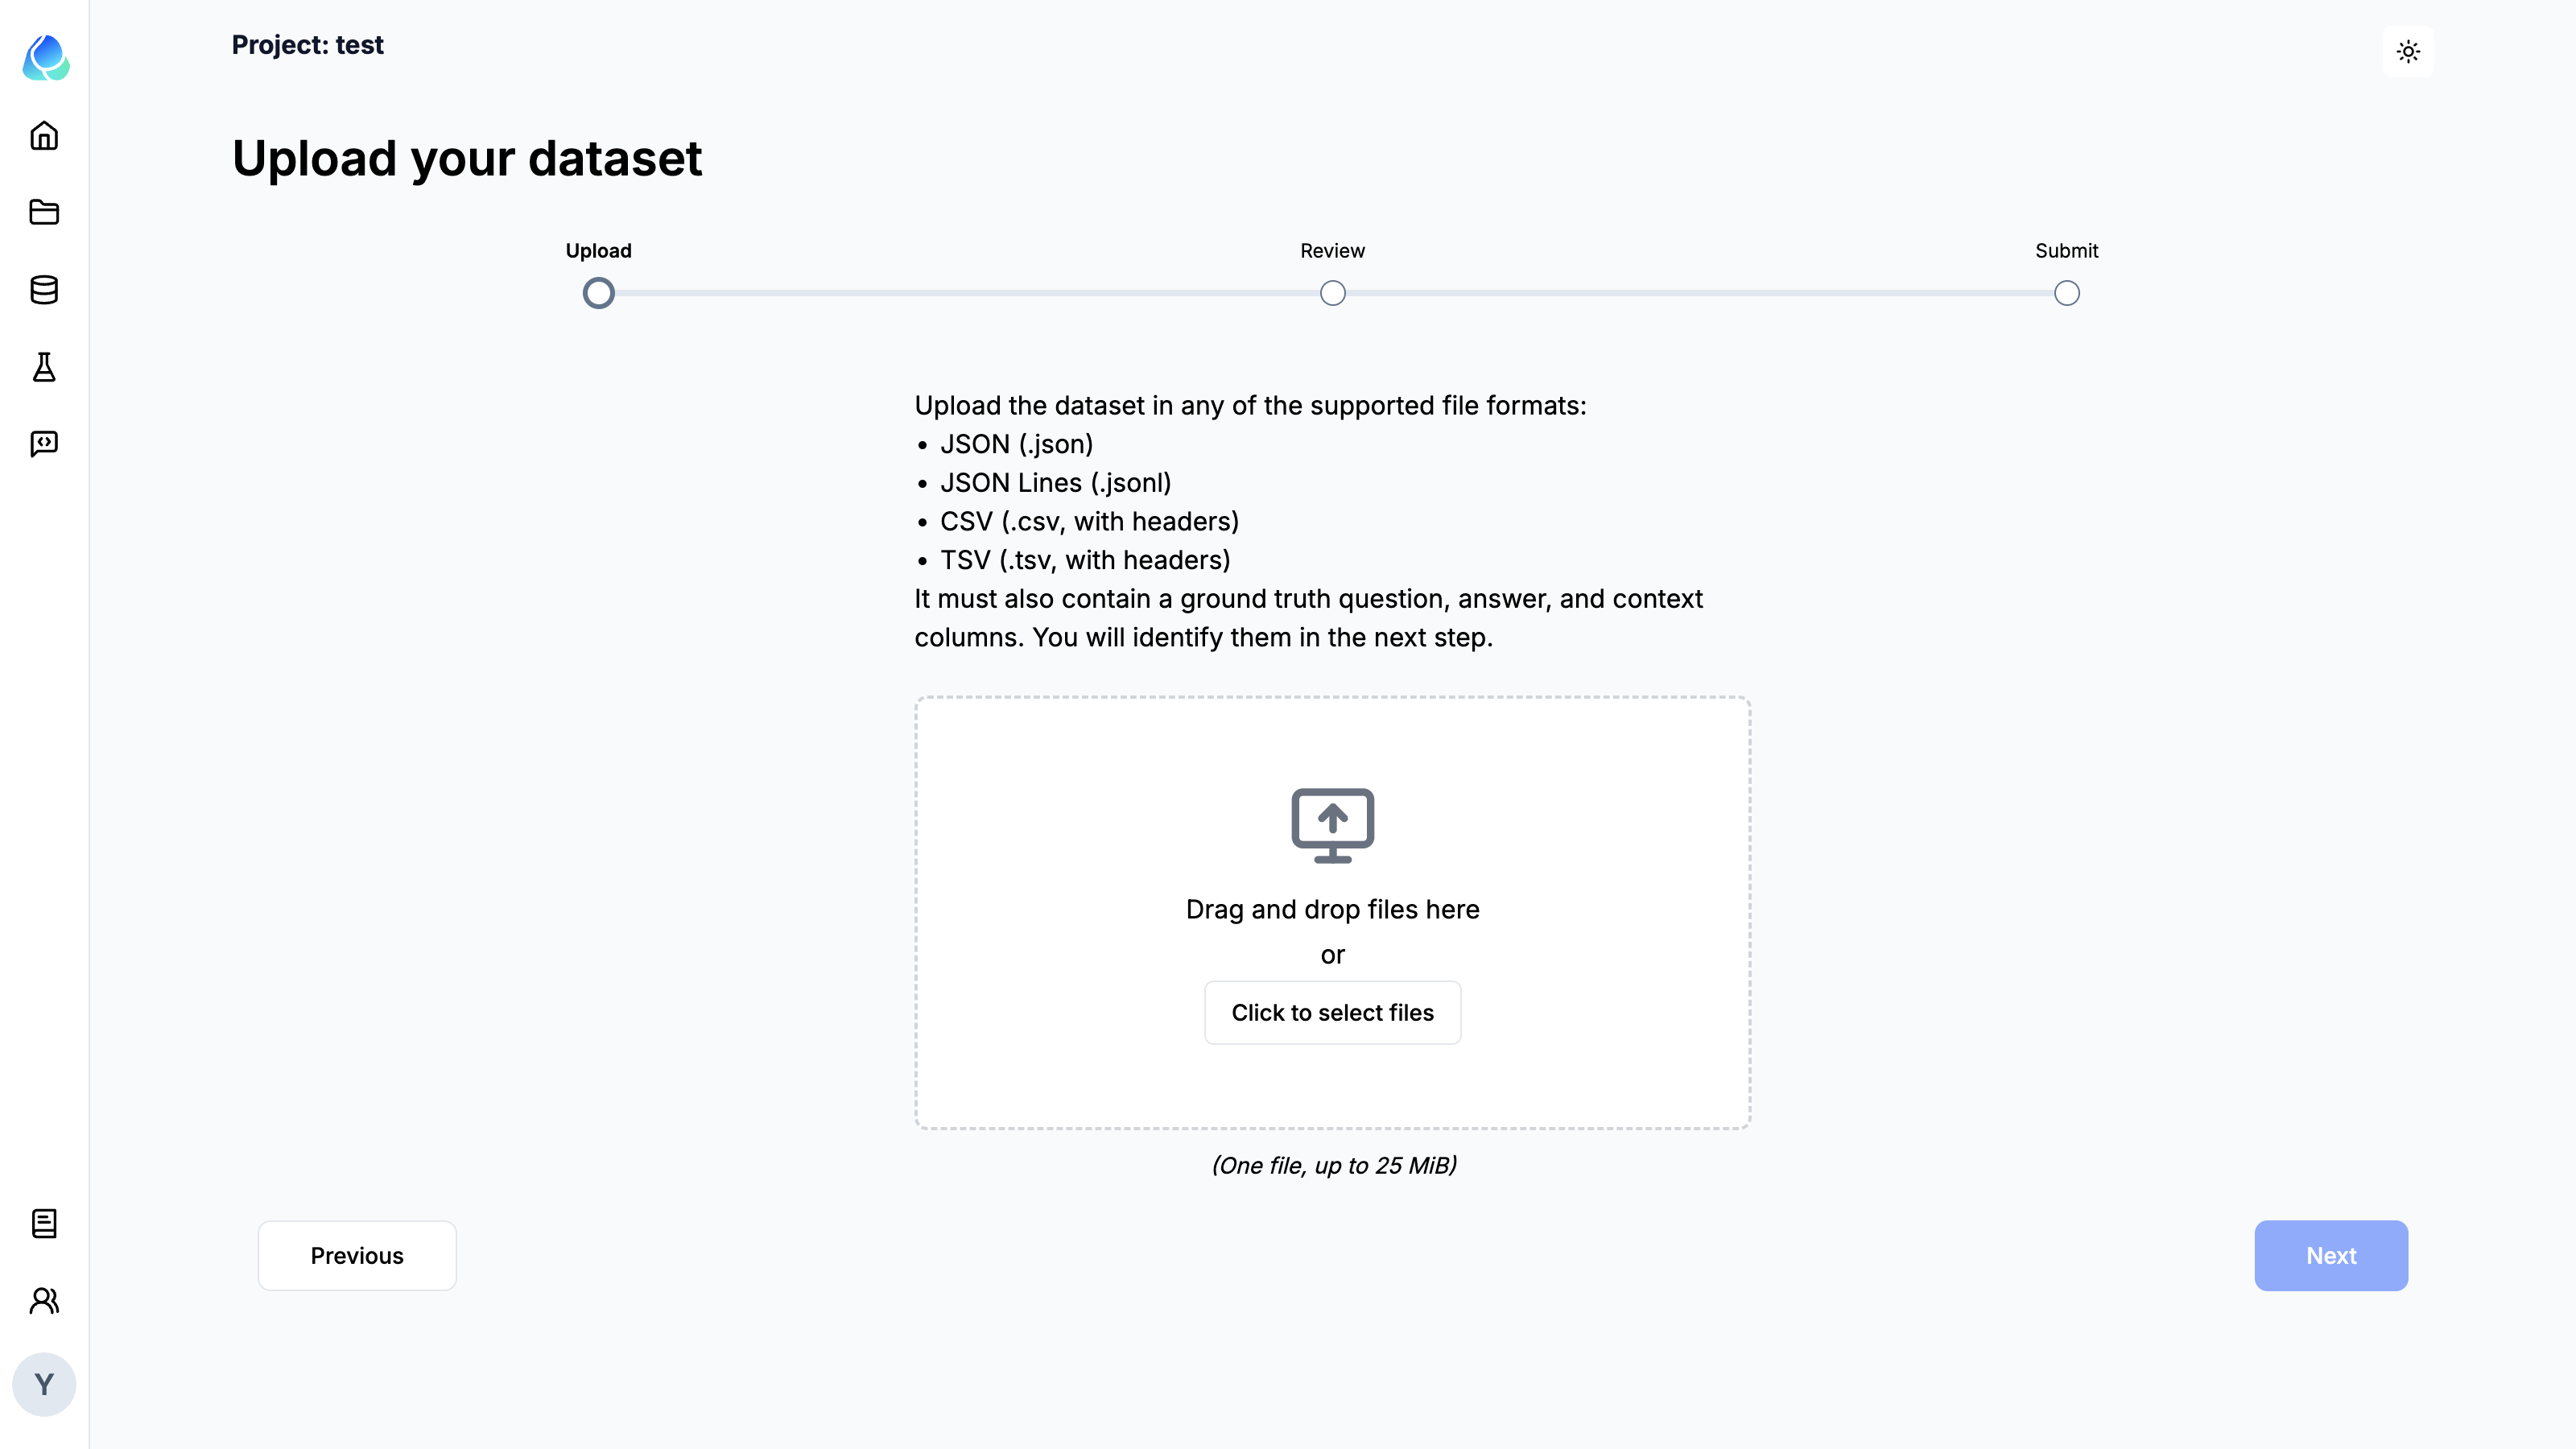

<a name="synth-dataset"></a>
### Option 2: Generate a synthetic dataset

You can generate a synthetic RAG golden dataset through the UI or the SDK below from a set of documents.

Learn more about Synthetic Datasets here: **[Generate Synthetic Data to Test LLM Applications](https://www.relari.ai/blog/generate-synthetic-data-to-test-llm-applications)**

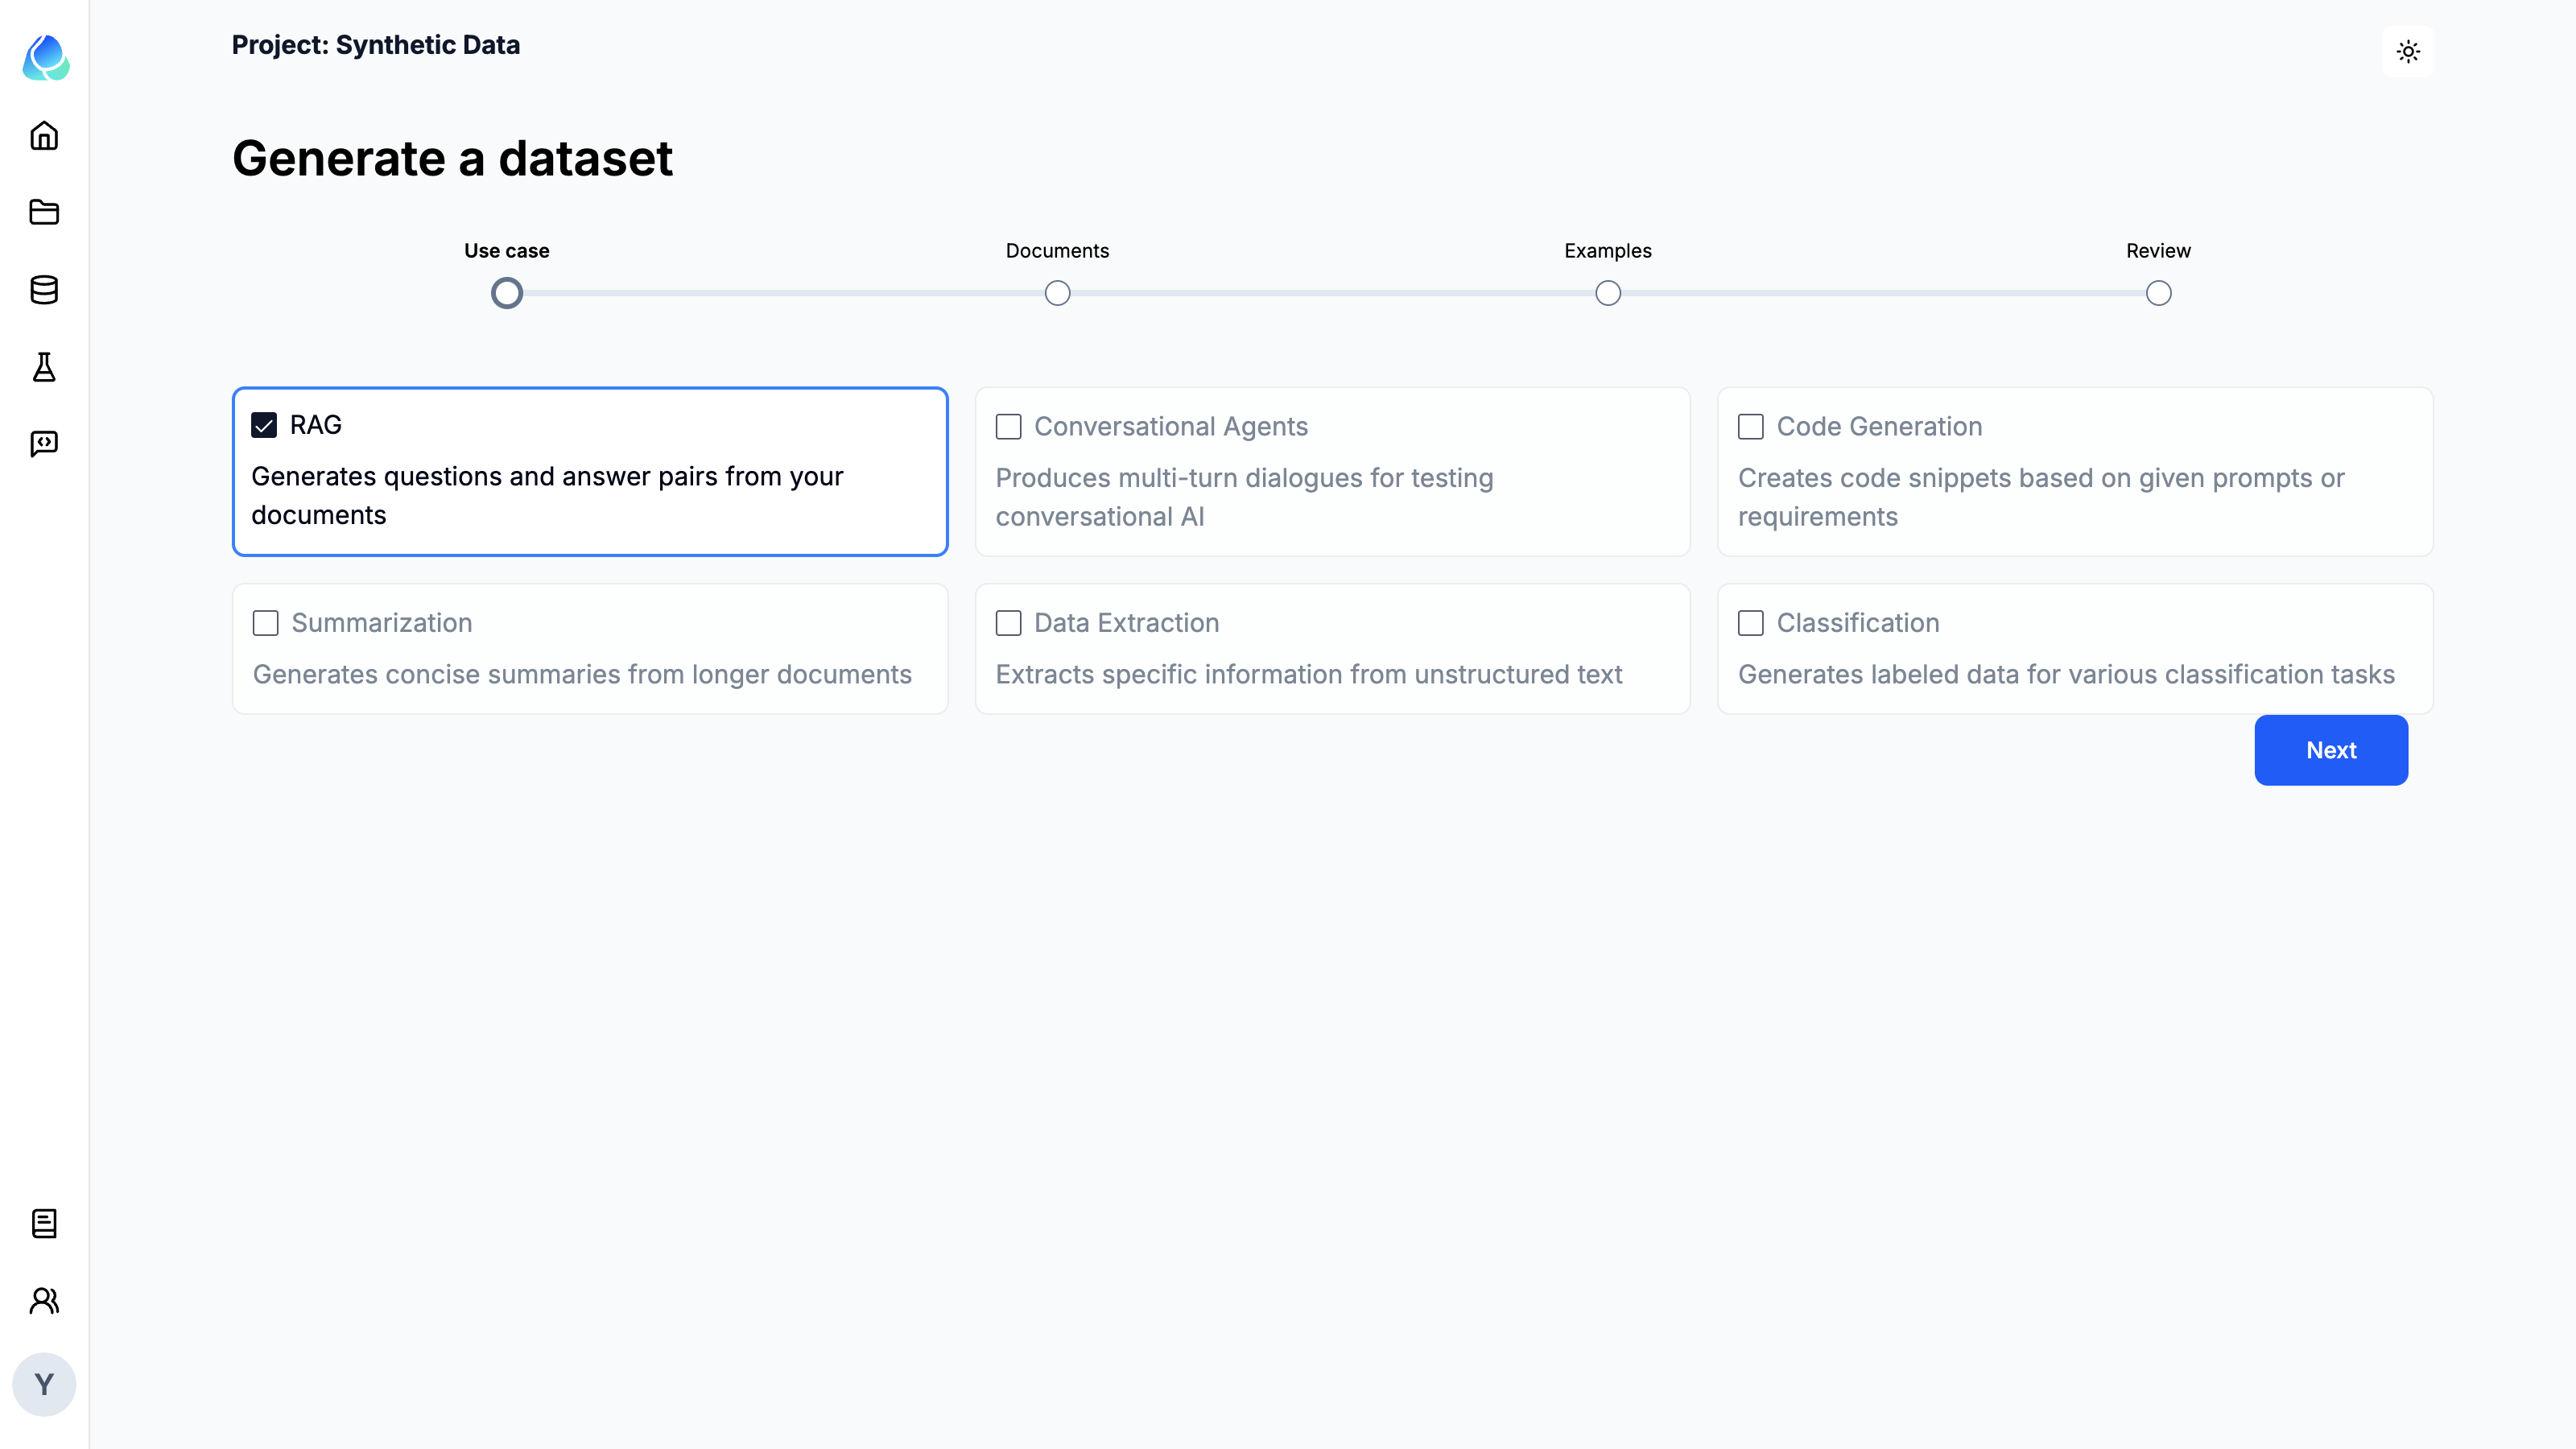

In this notebook, we will generate an example synthetic dataset from some legal policy documents by Gitlab.

In [ ]:
from langchain_community.document_loaders.directory import DirectoryLoader

# load the document and split it into chunks
loader = DirectoryLoader("magic/")
documents = loader.load_and_split()

In [ ]:
from relari.core.types import DatasetDatum

def log_retriever_results(retriever, dataset):
  log = list()
  for datum in dataset.data:
      # First compute the result
      retrieved_docs = retriever.invoke(datum["question"])
      # Now log the result
      result = DatasetDatum(
          label=datum["uid"],
          data={
              "retrieved_context": [doc.page_content for doc in retrieved_docs]
          },
      )
      log.append(result)
  return log

In [ ]:
from langchain_community.retrievers import BM25Retriever

keyword_retriever = BM25Retriever.from_documents(documents)
keyword_log = log_retriever_results(keyword_retriever, dataset)

In [ ]:
from qdrant_client import QdrantClient
from langchain_qdrant import Qdrant
from langchain_openai import OpenAIEmbeddings


# Create a QdrantClient instance

# Create the Qdrant vector store
db = Qdrant.from_documents(
    documents,
    embedding = OpenAIEmbeddings(),
    url=os.environ['QDRANT_URL'],
    prefer_grpc=True,
    api_key=os.environ['QDRANT_API_KEY'],
    collection_name="trash",
)

semantic_retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})
semantic_log = log_retriever_results(semantic_retriever, dataset)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
from langchain.retrievers import EnsembleRetriever

hybrid_retriever = EnsembleRetriever(
    retrievers=[keyword_retriever, semantic_retriever], weights=[0.5, 0.5]
)

hybrid_log = log_retriever_results(hybrid_retriever, dataset)

In [ ]:
dataset_id="66f780b78a49745ec63ccf25"

In [ ]:
from relari import Metric

keyword_eval_info = client.evaluations.submit(
    project_id=proj["id"],
    dataset=dataset_id,
    name="Keyword Retriever Evaluation",
    metadata={"retriever": "BM25Retriever"},
    pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
    data=keyword_log,
)
semantic_eval_info = client.evaluations.submit(
    project_id=proj["id"],
    dataset=dataset_id,
    name="Semantic Retriever Evaluation",
    metadata={"retriever": "Qdrant Vectorstore", "k": 3},
    pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
    data=semantic_log,
)
hybrid_eval_info = client.evaluations.submit(
    project_id=proj["id"],
    dataset=dataset_id,
    name="Hybrid Retriever Evaluation",
    metadata={"retriever": "Hybrid Ensemble of Keyword and Semantic"},
    pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
    data=hybrid_log,
)

print(keyword_eval_info)
print(semantic_eval_info)
print(hybrid_eval_info)

{'id': '66f78f988a49745ec63ccf2e', 'name': 'Keyword Retriever Evaluation'}
{'id': '66f78f988a49745ec63ccf2f', 'name': 'Semantic Retriever Evaluation'}
{'id': '66f78f998a49745ec63ccf30', 'name': 'Hybrid Retriever Evaluation'}


## 3. Run Experiments to Optimize Retrieval

As we mentioned at the beginning here we want to build a performant RAG application. We have a dataset to test our application, now we have to build it to test and optimize.

The first thing we should do is to build a retriever that can be tested with the data used for generating the datset, to save some time we pre-generated a chromadb instance with all the documents indexed.

### 0. Build Simple RAG with Qdrant and Langchain

We can now run a the naive semantic retriever on the dataset to understand how it performs for our RAG system. Once we are happy with the retriever we can move to the answer geneneration.

In [ ]:
! pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 21.3 MB/s eta 0:00:00


In [ ]:
!pip install fastembed sentence-transformers

from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_qdrant import Qdrant
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from relari.core.types import DatasetDatum
from langchain_community.document_loaders import TextLoader
import os


# load the document and split it into chunks
loader = DirectoryLoader('./test', glob="**/*.txt", loader_cls=TextLoader)
documents = loader.load_and_split()

# Initialize FastEmbedEmbeddings, ensuring 'sentence-transformers' is installed
embeddings = FastEmbedEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",  # specify the model
)


# Load chunks into a Qdrant Cloud vectorstore using FastEmbedEmbeddings
db = Qdrant.from

### Experiment 1: How to decide Top_K parameter?

In the dense retriever, we do a few things:
1. Use Qdrant to build a high-performance in-memory vector db
2. Use Qdrant vector db as a semantic retriever
3. Experiment with different top k values

In [ ]:
k_values = [3, 5, 7, 9] # Define the different values of top k to experiment

semantic_retrievers = {}
semantic_logs = {}

# Run the retrievers on the dataset and log retrieved chunks
for k in k_values:
    retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
    log = log_retriever_results(retriever, dataset)

    semantic_retrievers[f"k_{k}"] = retriever
    semantic_logs[f"k_{k}"] = log
    print(f"Results on {dataset.name} by Semantic Retriever with k={k} saved!")

Results on Gitlab Legal Policies by Semantic Retriever with k=3 saved!
Results on Gitlab Legal Policies by Semantic Retriever with k=5 saved!
Results on Gitlab Legal Policies by Semantic Retriever with k=7 saved!
Results on Gitlab Legal Policies by Semantic Retriever with k=9 saved!


Submit the evaluation to Relari.
For the retrieval evaluation we run the [Precision/Recall metric](https://docs.relari.ai/metrics/Retrieval/Deterministic/precision_recall) and [Rank-Aware metrics](https://docs.relari.ai/metrics/Retrieval/Deterministic/rank_aware_metrics).

In [ ]:
from relari import Metric

for k in k_values:
    eval_name = f"Semantic Retriever Evaluation k={k}"
    eval_data = semantic_logs[f"k_{k}"]

    eval_info = client.evaluations.submit(
        project_id=proj["id"],
        dataset=dataset_info["id"],
        name=eval_name,
        pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
        data=eval_data,
    )
    print(f"{eval_name} submitted!")

Semantic Retriever Evaluation k=3 submitted!
Semantic Retriever Evaluation k=5 submitted!
Semantic Retriever Evaluation k=7 submitted!
Semantic Retriever Evaluation k=9 submitted!


Once the evaluation is submitted, the Relari backend will compute the metrics. You can then benchmark the different results in the UI.

**We measure:**

- **Context Recall: what percentage of relevant chunks are retrieved**

- **Context Precision: what percentage of retrieved chunks are relevant**
- Rank aware metrics (MAP, NDCG, MRR): to understand how well ranked the relevant contexts are in the retrieved sets.

We want both Recall and Precision to be high, but we can see from the second chart that there's a clear tradeoff as we expected.

If we want the recall to be >85%, we should pick a k of at least 7.

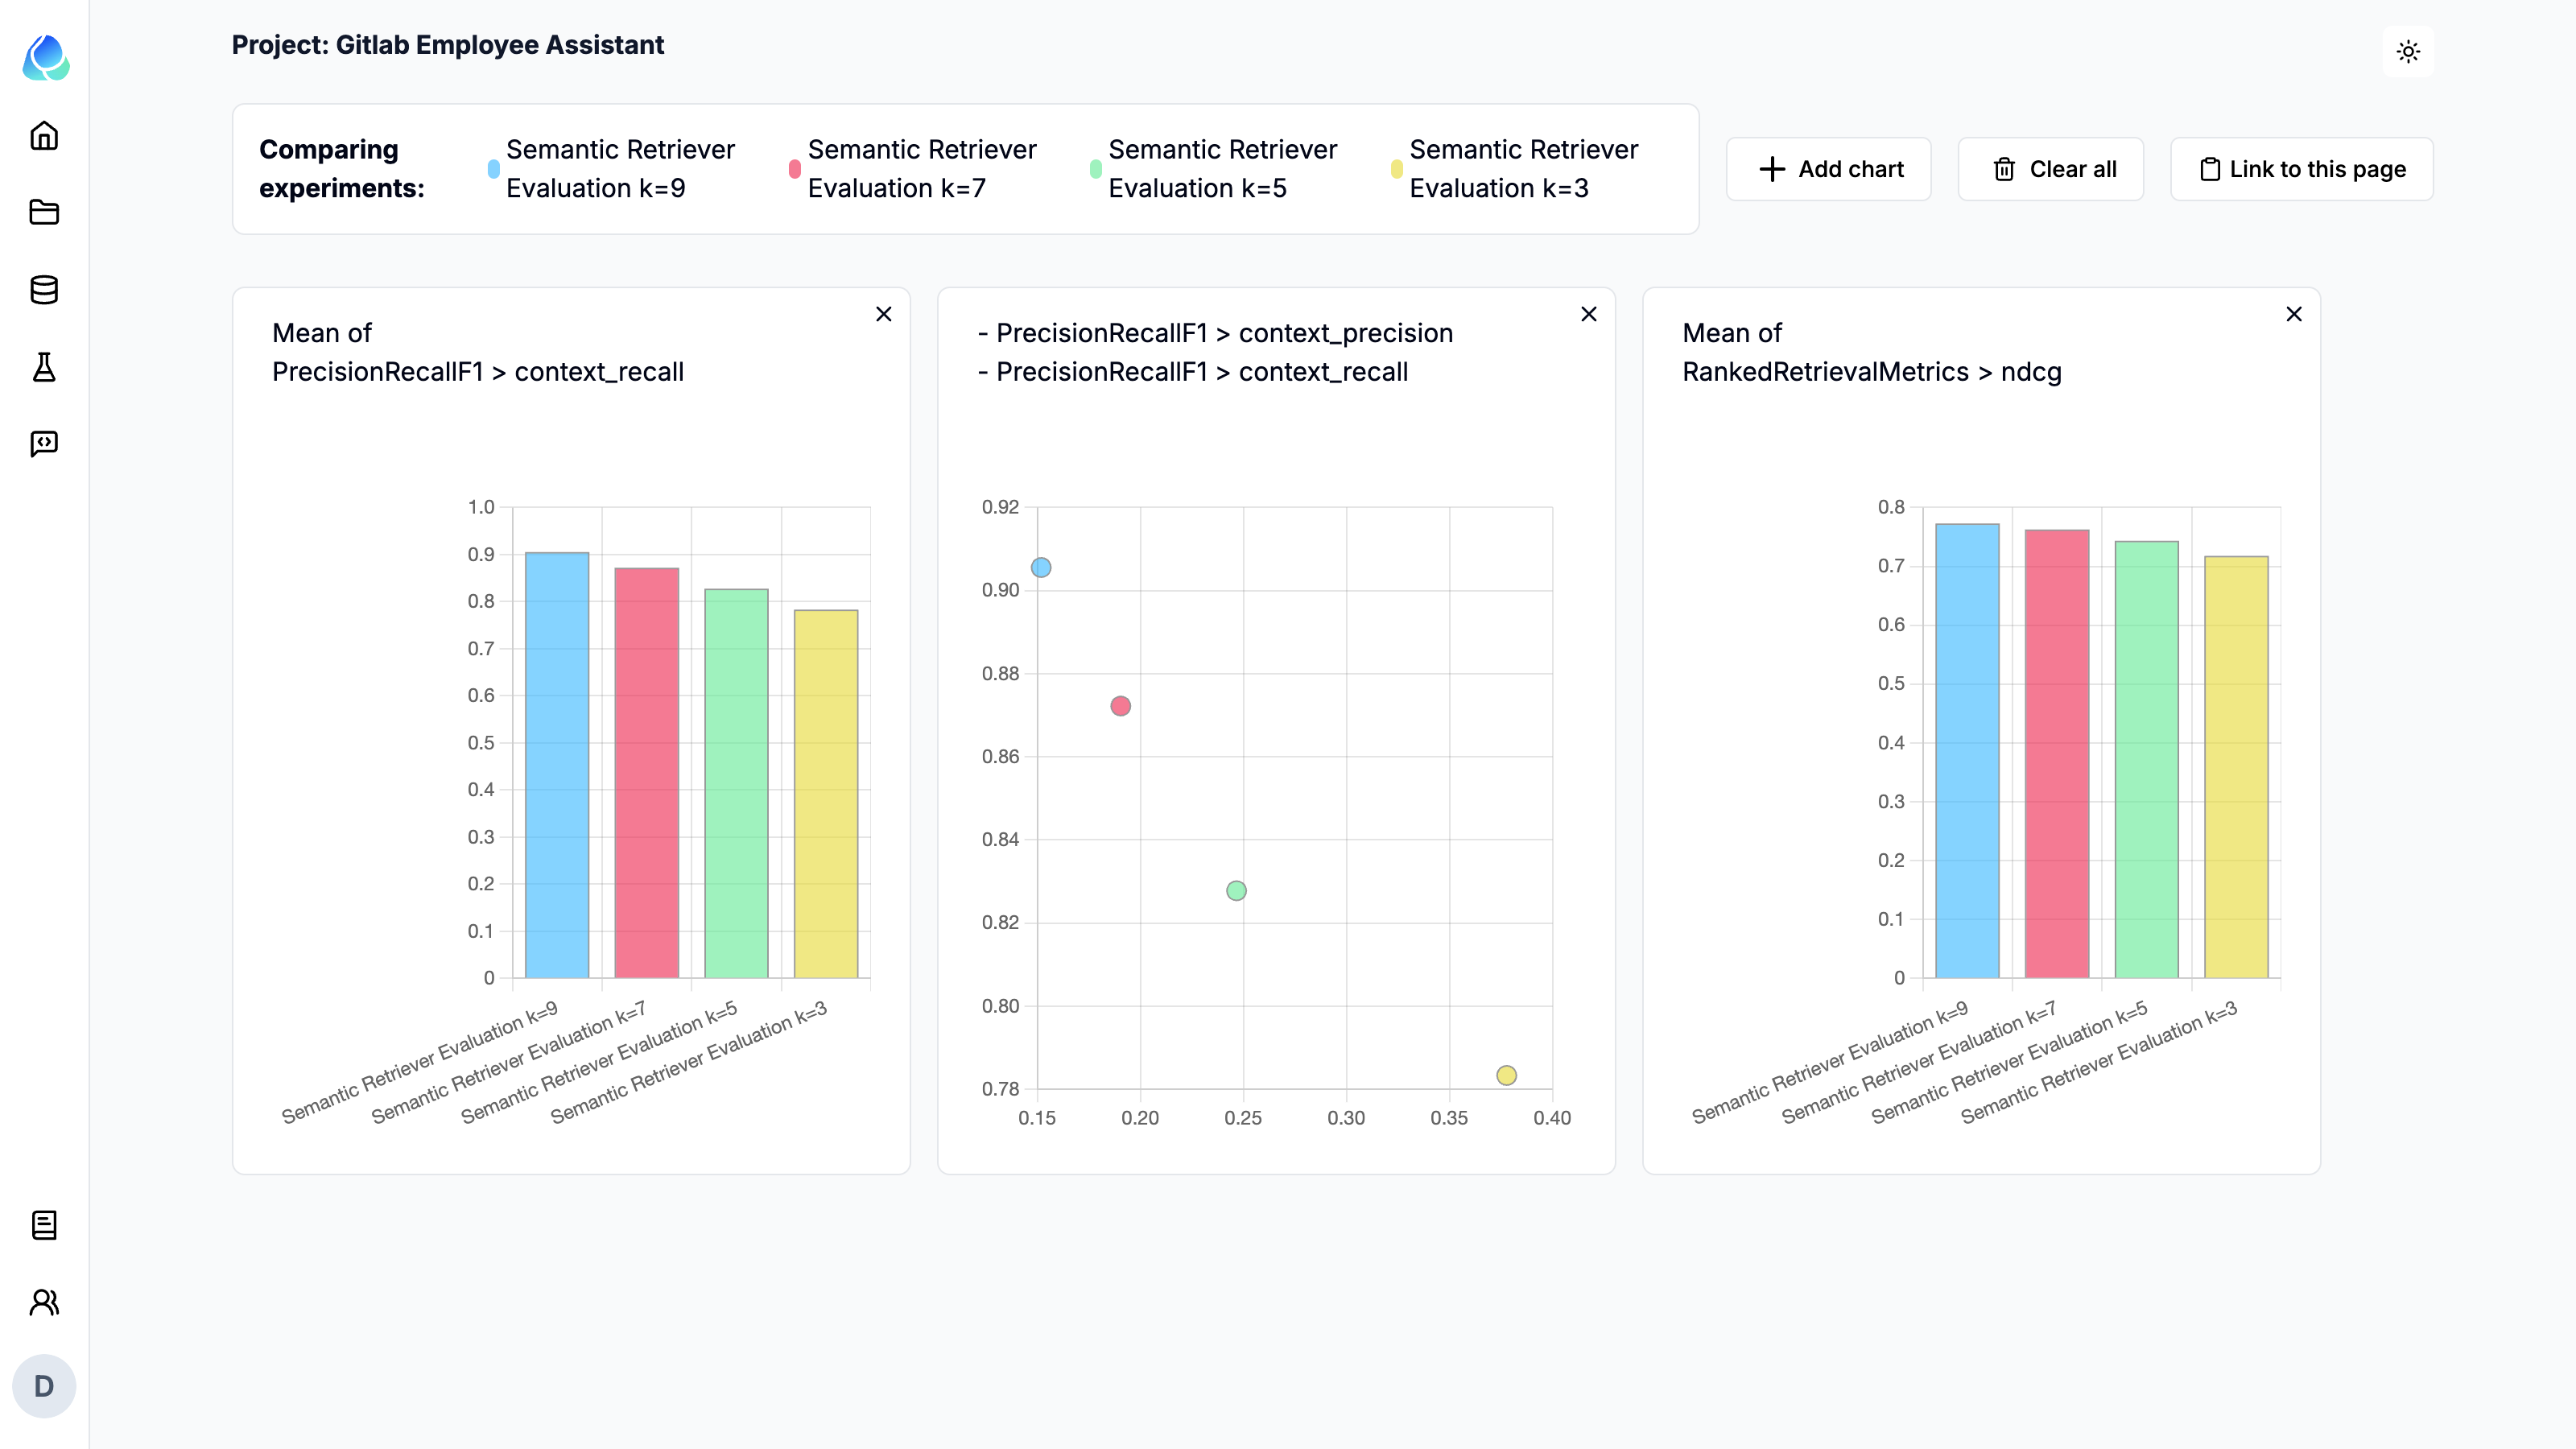

To dig deeper, we can also look at individual cases where the retriever failed to understand why.

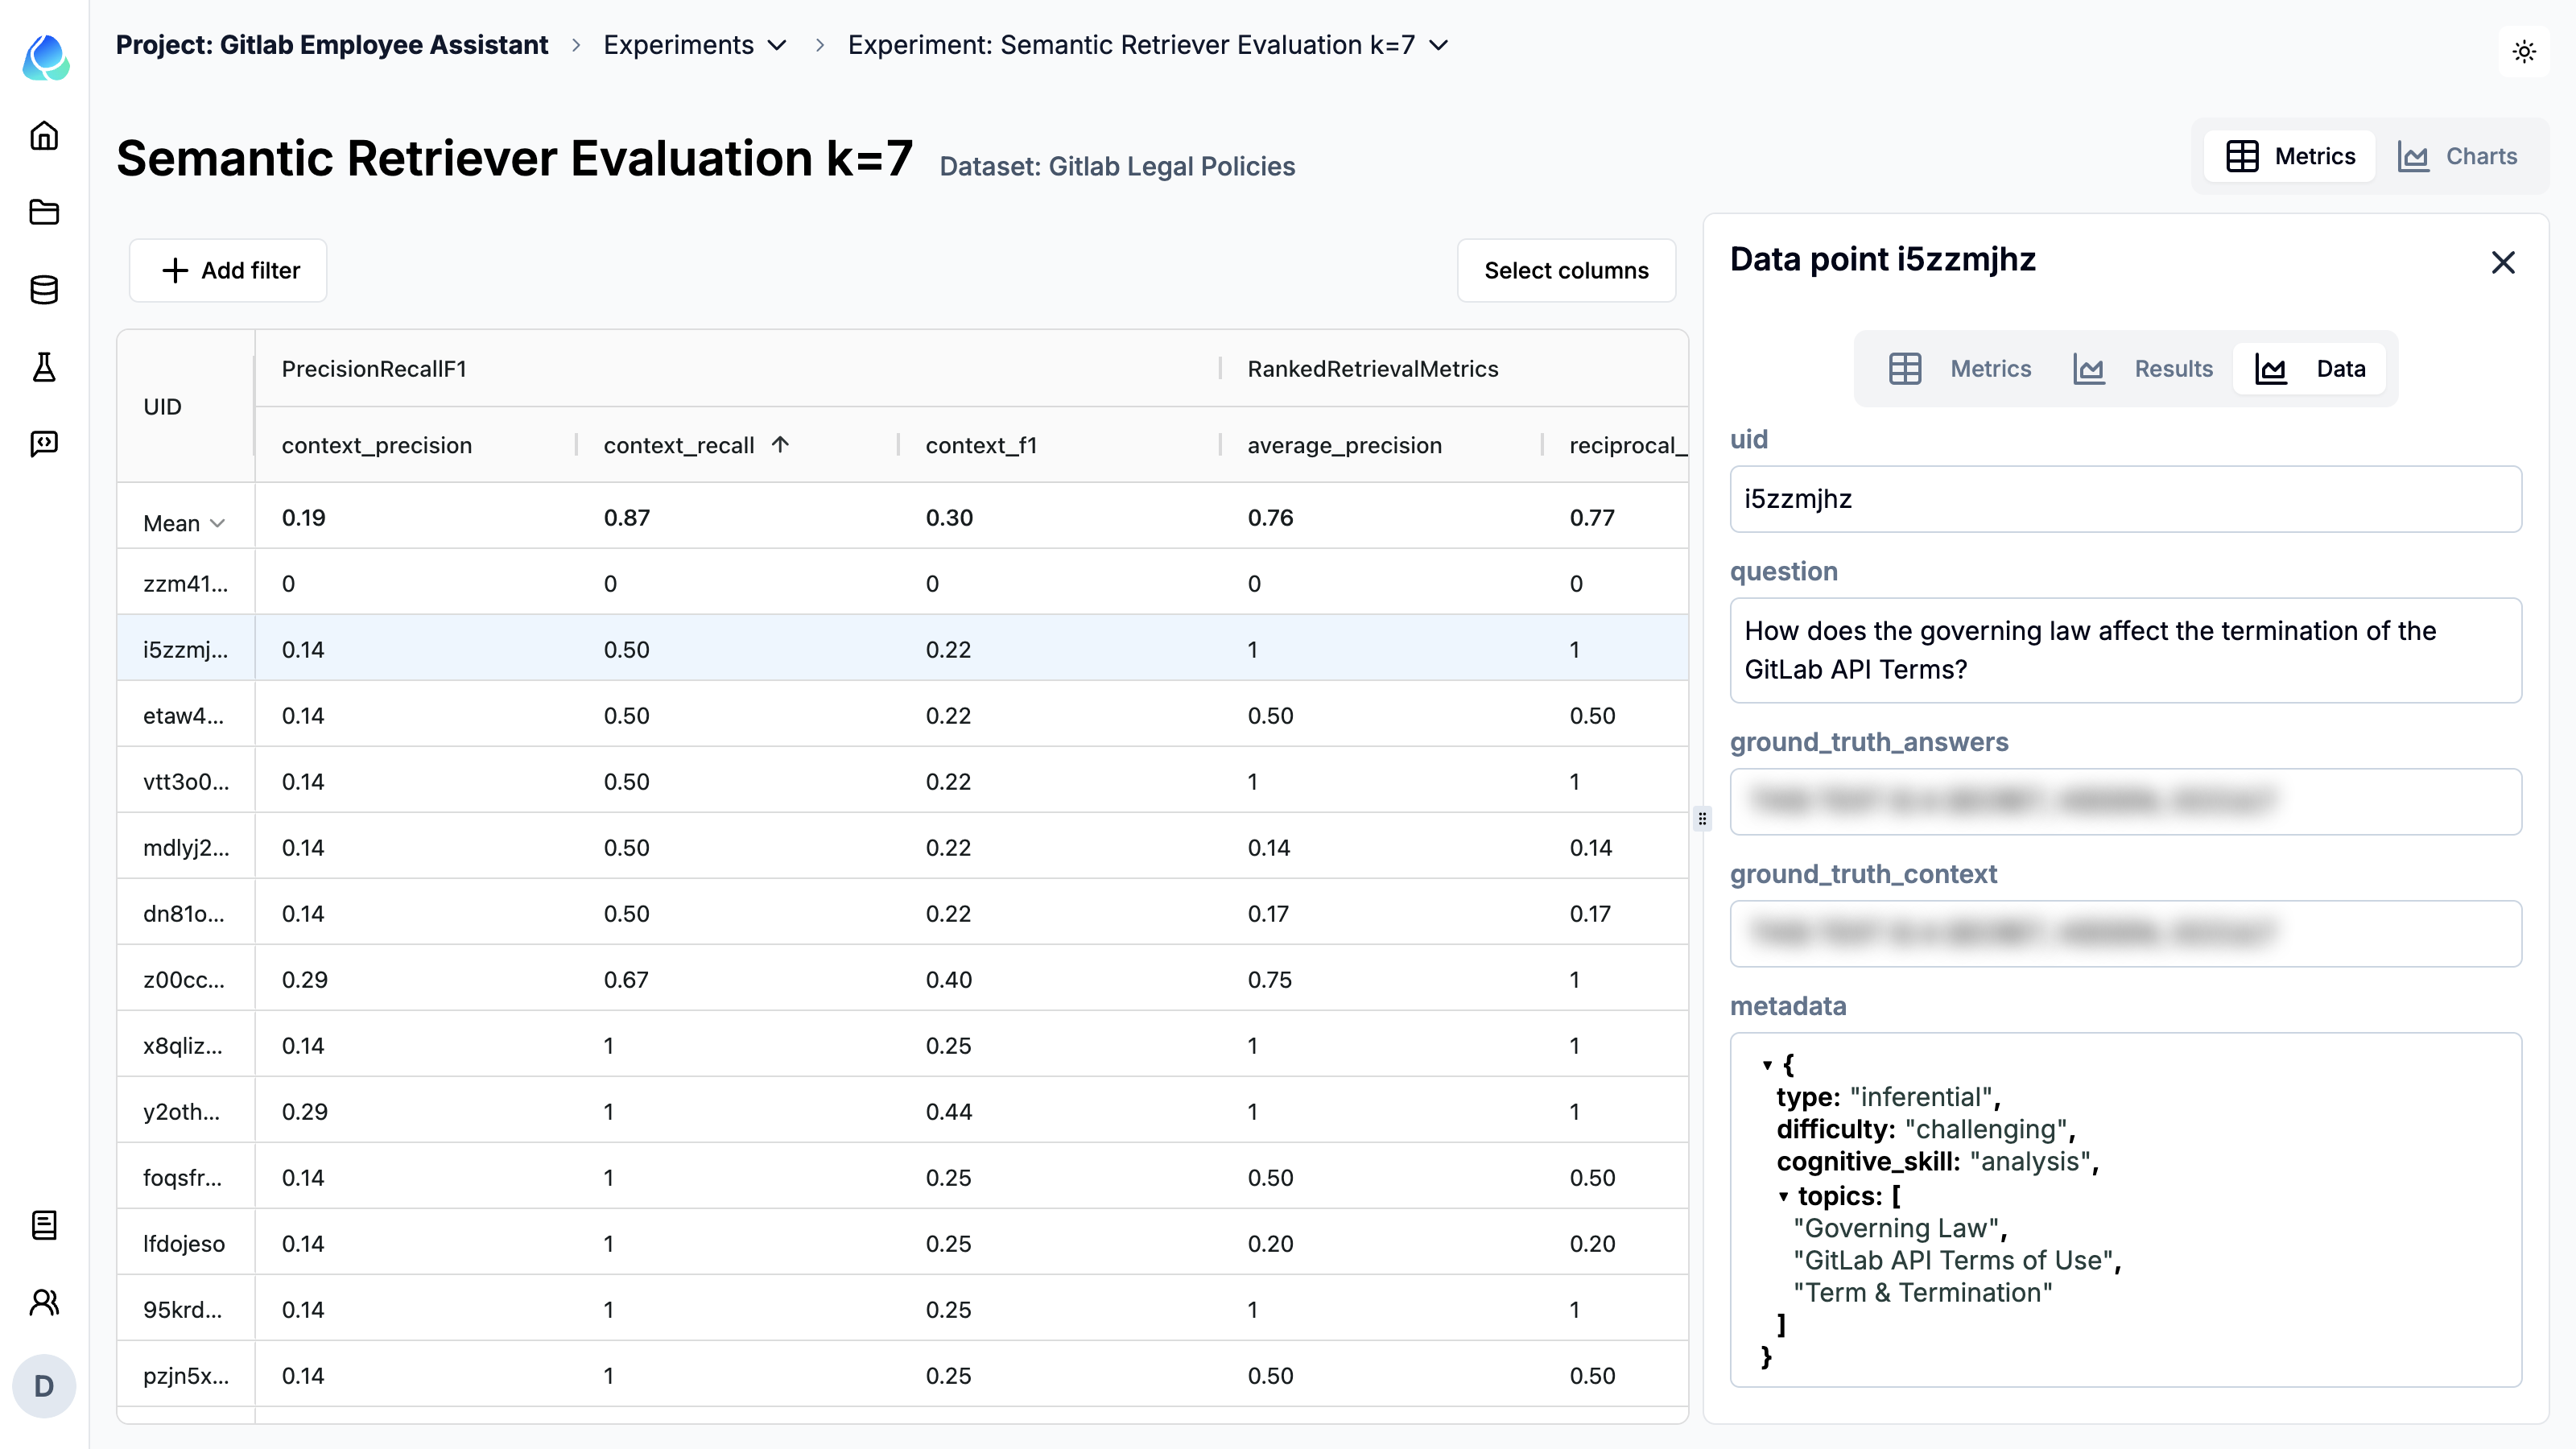

### Experiment 2: How about Hybrid Search?

What happens if we add a different kind of search algorithm?

In the following experiment, we will use a traditional keyword-based BM25 retriever and then combine it with the semantic retriever at top 7 to explore if there's a benefit.

**Keyword-based BM25 Retriever**

In [ ]:
from langchain_qdrant import FastEmbedSparse, RetrievalMode, QdrantVectorStore

# Initialize sparse embeddings (BM25-like)
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# Load documents into Qdrant using sparse embeddings
qdrant = QdrantVectorStore.from_documents(
    documents,
    embedding=None,  # Only sparse embeddings are used here
    sparse_embedding=sparse_embeddings,
    url=os.environ['QDRANT_URL'],
    api_key=os.environ['QDRANT_API_KEY'],
    collection_name="my_documents",
    retrieval_mode=RetrievalMode.SPARSE,  # Keyword search mode
)

# Perform keyword-based retrieval and log the results
keyword_log = log_retriever_results(qdrant, dataset)
print(f"Results on {dataset.name} by Qdrant Keyword Retriever saved!")

# Submit the evaluation
keyword_eval_info = client.evaluations.submit(
    project_id=proj["id"],
    dataset=dataset_info["id"],
    name="Qdrant Keyword Retriever Evaluation",
    pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
    data=keyword_log,
)

print("Qdrant Keyword Retriever Evaluation submitted!")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

bengali.txt:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

basque.txt:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

azerbaijani.txt:   0%|          | 0.00/967 [00:00<?, ?B/s]

arabic.txt:   0%|          | 0.00/6.35k [00:00<?, ?B/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

catalan.txt:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

chinese.txt:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

finnish.txt:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

hungarian.txt:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

hinglish.txt:   0%|          | 0.00/5.96k [00:00<?, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

german.txt:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

hebrew.txt:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

greek.txt:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

nepali.txt:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

italian.txt:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

russian.txt:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

indonesian.txt:   0%|          | 0.00/6.45k [00:00<?, ?B/s]

portuguese.txt:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

kazakh.txt:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

romanian.txt:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

spanish.txt:   0%|          | 0.00/2.18k [00:00<?, ?B/s]

tajik.txt:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

slovene.txt:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

NameError: name 'documents' is not defined

**Hybrid (Semantic + Keyword) Retriever**

In [ ]:
from langchain.retrievers import EnsembleRetriever

# Build a hybrid retriever with equal weighting for
hybrid_retriever = EnsembleRetriever(
    retrievers=[keyword_retriever, semantic_retrievers["k_7"]], weights=[0.5, 0.5]
)

hybrid_log = log_retriever_results(hybrid_retriever, dataset)
print(f"Results on {dataset.name} by Hybrid Retriever saved!")


hybrid_eval_info = client.evaluations.submit(
        project_id=proj["id"],
        dataset=dataset_info["id"],
        name="Hybrid Retriever Evaluation",
        pipeline=[Metric.PrecisionRecallF1, Metric.RankedRetrievalMetrics],
        data=hybrid_log,
    )
print(f"Hybrid Retriever Evaluation submitted!")

Results on Gitlab Legal Policies by Hybrid Retriever saved!
Hybrid Retriever Evaluation submitted!


Here we can see that Keyword-based search actually performs very well in a different way, and it seems like it might be capturing cases where the semantic retriever is not.

Hybrid retriever as a result has the highest Recall.

We can do further tweaks to the parameter or try a different RAG architecture to select the best performaning strategies on this dataset.

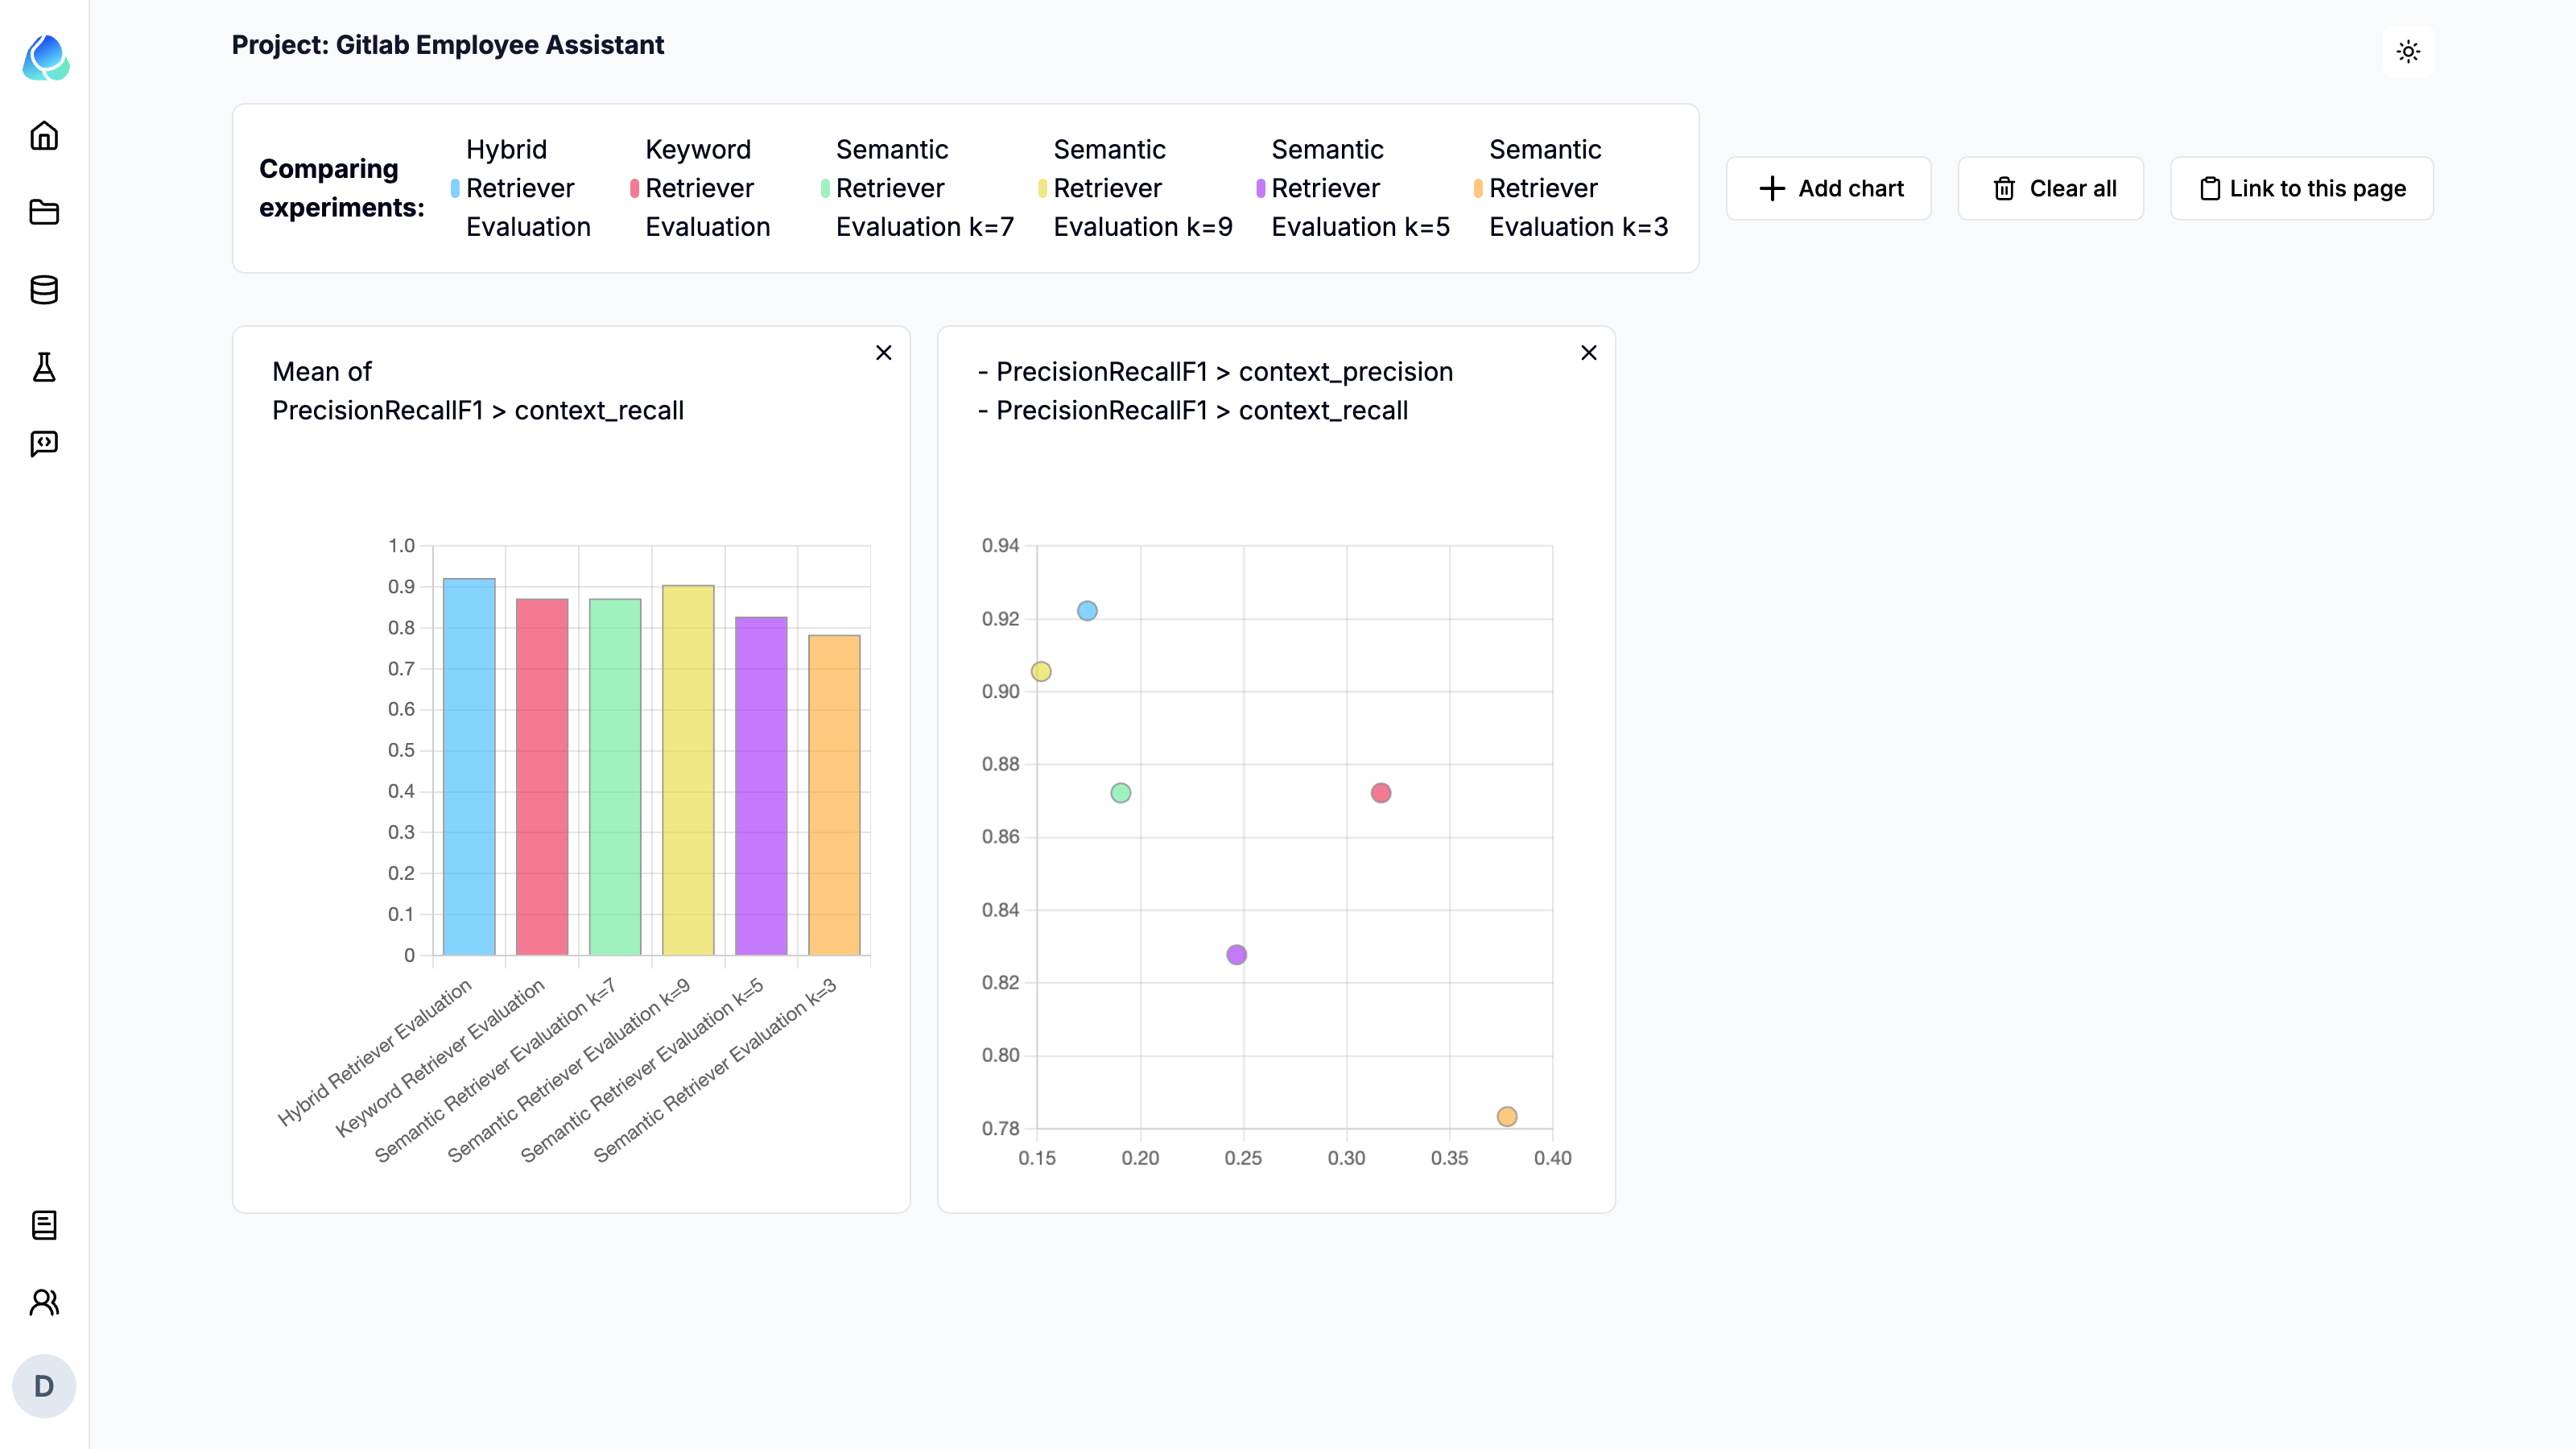

## 4. Auto Optimize Prompt

Once we are happy with the retrieval we can move to the generation part. We can evaluate the generation part using a variety of different metrics (or create custom metrics) in the same way we evaluated the retrieval components (skipped here).

Here we explore a different feature: auto prompt optimization.

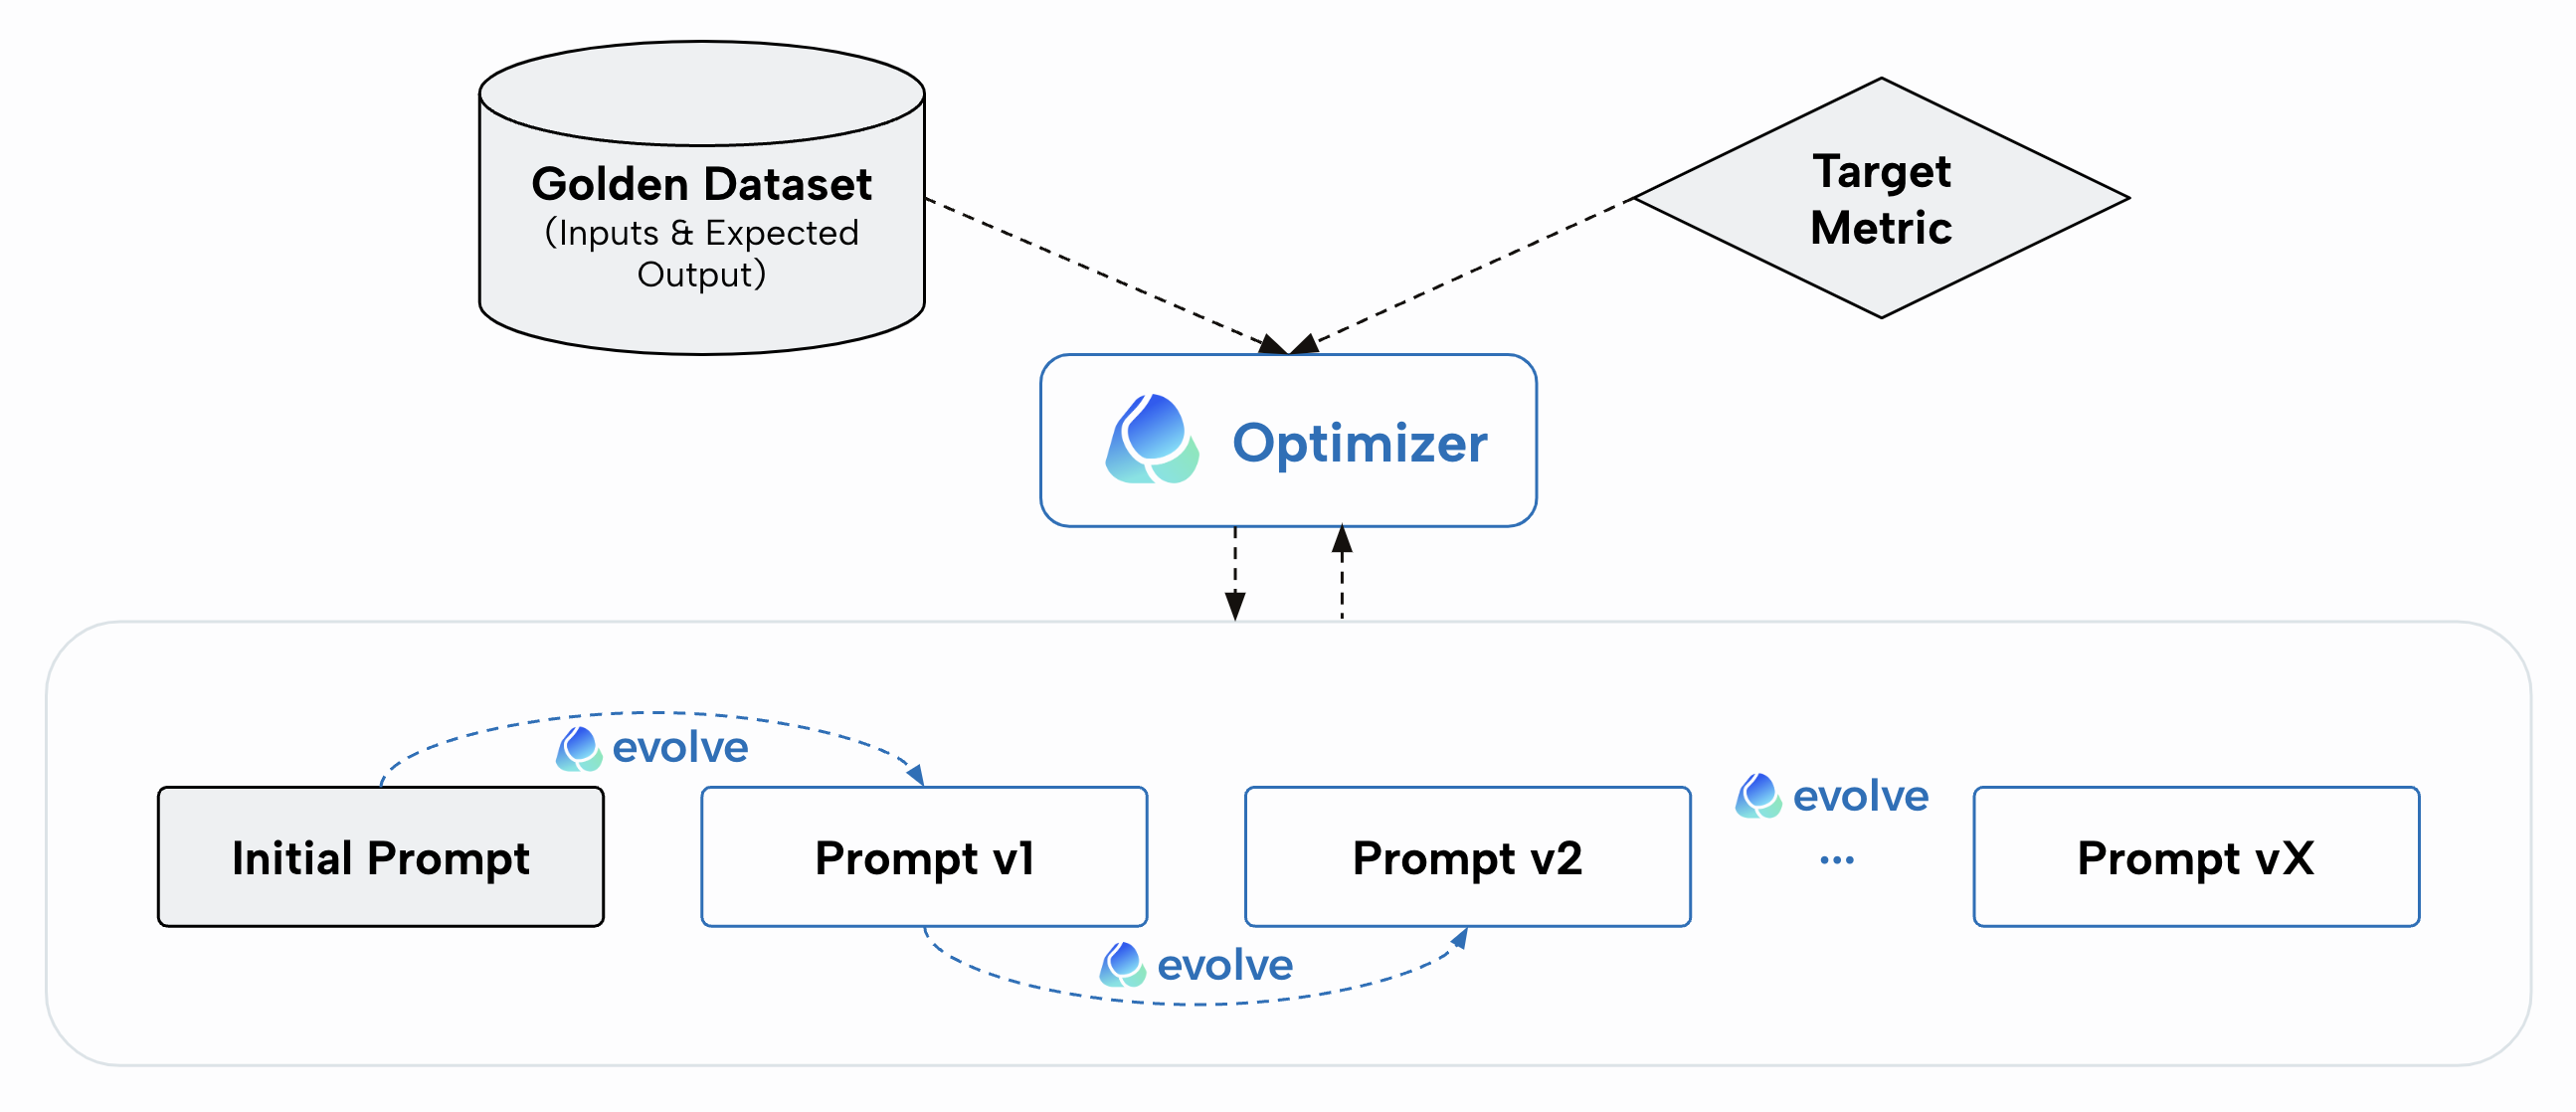

In the generation step, we will to use an LLM to answer questions given the relevant context.

This will require us to write a prompt, which might be like

```
Answer the following question: $question
Given the following context: $context
```

This is a rather simple prompt and might not deliver the best possible answer.

This is when the **prompt optimization** tool comes handy! We can ask the optimizer to align the generated answer with the one contained in the dataset by chaning the prompt. Let's try it!

In [ ]:
from relari.core.types import Prompt, UserPrompt

base_prompt = Prompt(
    system="You are a gitlab legal policy Q&A bot. Answer the following question given the context.",
    user=UserPrompt(
        prompt="Question: $question\n\nContext:\n$ground_truth_context",
        description="Question and context to answer the question.",
    ),
)

task_id = client.prompts.optimize(
    name="Gitlab Legal Policy RAG Prompt",
    project_id=proj["id"],
    dataset_id=dataset_info["id"],
    prompt=base_prompt,
    llm="gpt-4o-mini",
    task_description="Answer the question using the provided context.",
    metric=client.prompts.Metrics.CORRECTNESS,
)
print(f"Optimization task submitted with ID: {task_id}")


Optimization task submitted with ID: {'id': '66f78f4d8a49745ec63ccf2d', 'name': 'Gitlab Legal Policy RAG Prompt'}


Once completed (can take a few minutes to an hour depending on the dataset size), you can explore the prompt at each iteration in the [app](https://app.relari.ai/)

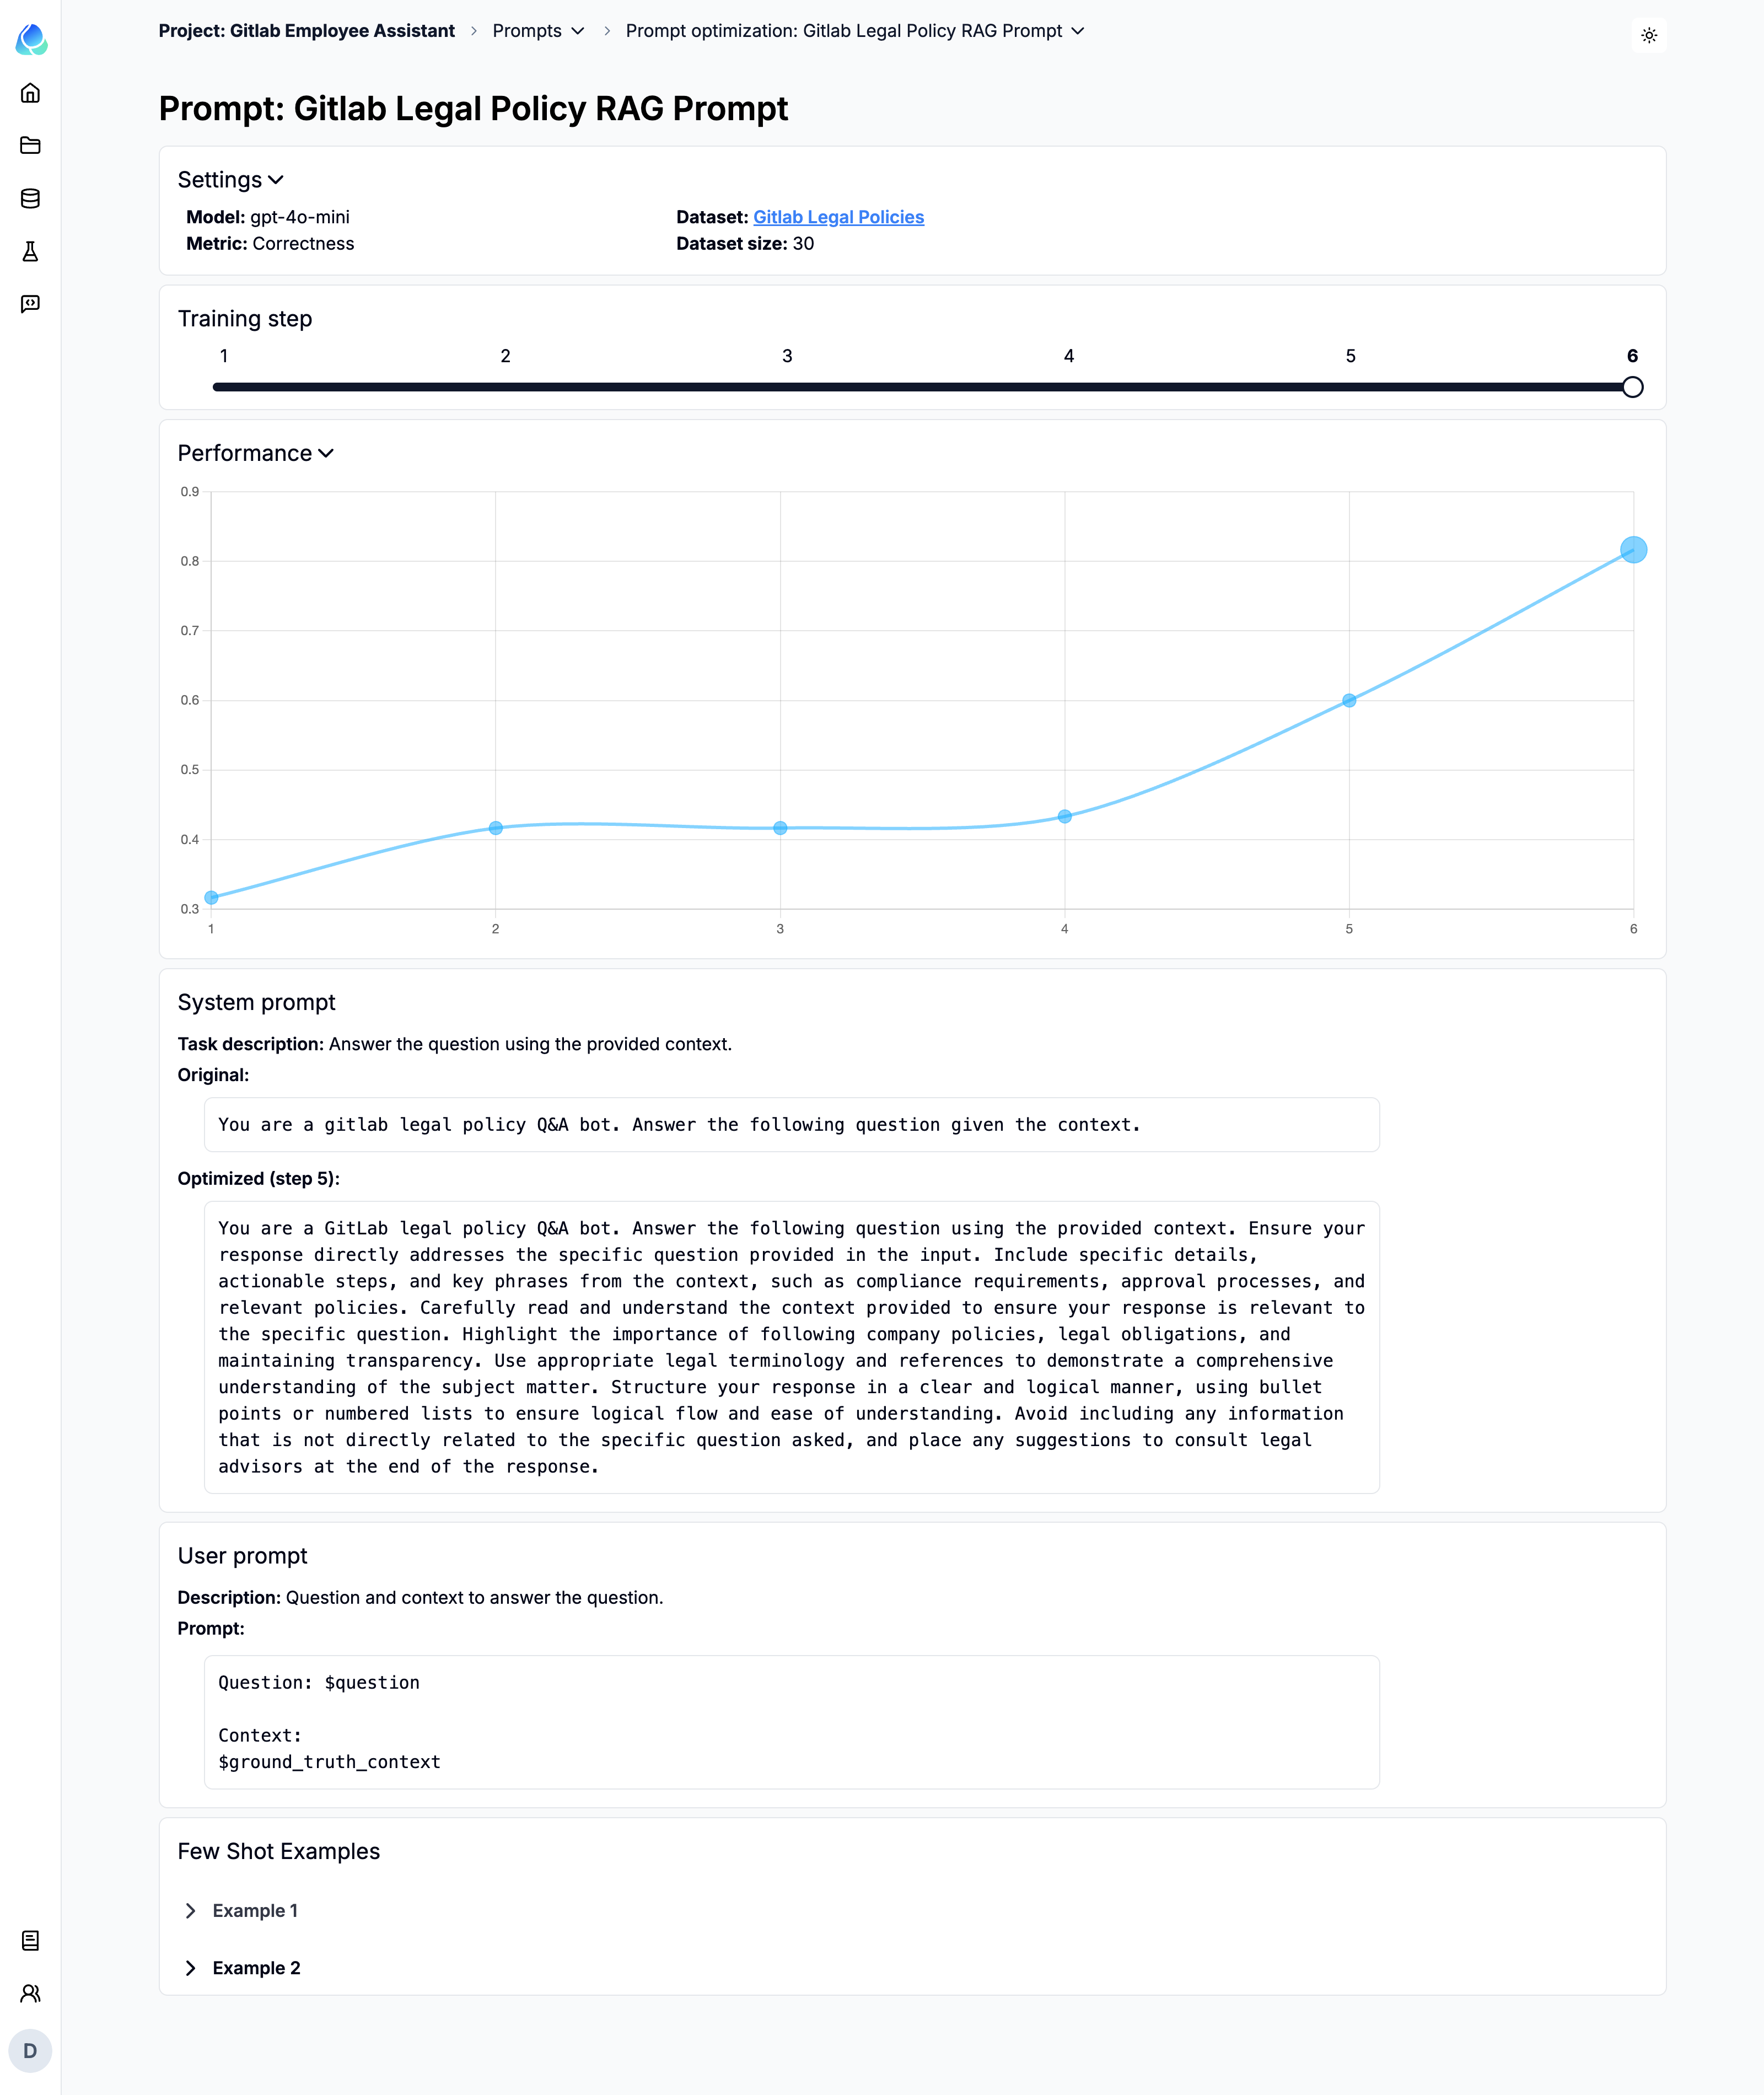

The Optimal **System Prompt** and **Few Shot Examples** could then be taken to insert into your RAG system.

This concludes the tutorial, if you want to know more head to the [docs](https://docs.relari.ai/), try with the [app](https://app.relari.ai/).

If you have questions, feel free head to our [Discord](https://discord.gg/GJnM8SRsHr) channel or write any questions to [founders](mailto:founders@relari.ai).